# Ćwiczenie 3

Celem ćwiczenia jest imlementacja metody [Minimax z obcinaniem alpha-beta](https://en.wikipedia.org/wiki/Alpha%E2%80%93beta_pruning) do gry Connect Four (czwórki).

W trakcie ćwiczenia można skorzystać z reposytorium z implementacją gry [Connect Four udostępnionym przez Jakuba Łyskawę](https://github.com/lychanl/two-player-games). Ewentualnie, można zaimplementować samemu grę Connect Four (ale, tak aby rozwiązanie miało ten sam interfejs co podany poniżej).

Implementację Minimax należy przetestować używając różną głębokość przeszukiwania. Implementacja Solvera musi zapewniać interfejs jak poniżej, ale można dodać dowolne metody prywatne oraz klasy wspomagające (jeżeli będą potrzebne).

Punktacja:
- Działająca metoda Minimax - **2 pkt**
- Działająca metoda Minimax z obcinaniem alpha-beta - **1.5 pkt**
- Analiza jakości solvera w zależności od głębokości przeszukiwania **1.5pkt**
    - należy zaimplementować w tym celu prostą wizualizację rozgrywki dwóch agentów, bądź kilka przykładów 'z ręki'
- Jakość kodu **2pkt**

Aby importowanie elementów z poniższej komórki działało należy umieścić tego notebooka w tym samym folderze co paczkę `two_player_games`:
```
├── LICENSE
├── README.md
├── minimax.ipynb # <<< HERE
├── test
│   ├── __init__.py
│   ├── test_connect_four.py
│   ├── test_dots_and_boxes.py
│   └── test_pick.py
└── two_player_games
    ├── __init__.py
    ├── games
    │   ├── connect_four.py
    │   └── dots_and_boxes.py
    ├── move.py
    ├── player.py
    └── state.py
```

In [2]:
from typing import Tuple, List
from random import choice
import numpy as np
import matplotlib.pyplot as plt
from two_player_games.player import Player
from two_player_games.games.connect_four import ConnectFour, ConnectFourMove

Wielkość planszy

In [20]:
ROW_COUNT = 6
COLUMN_COUNT = 7
MULTIPLIER = {0:0, 1: 0, 2: 10, 3: 30, 4: 3000}
INF = 99999999999999

def calculate_possible_lines(fields, rows=ROW_COUNT, columns=COLUMN_COUNT):
    possible_lines = []
    # vertical
    for i in range(columns):
        for j in range(rows-3):
            possible_lines.append([fields[i][k+j] for k in range(4)])

    # horizontal
    for i in range(rows):
        for j in range(columns-3):
            possible_lines.append([fields[k+j][i] for k in range(4)])

    # diagonal up
    for i in range(rows-3):
        for j in range(columns-3):
            possible_lines.append([fields[k+j][i+k] for k in range(4)])

    # diagonal down
    for i in range(rows-3):
        for j in range(3, columns):
            possible_lines.append([fields[j-k][i+k] for k in range(4)])


    return possible_lines

In [5]:
from typing import Tuple


from two_player_games.player import Player


class ConnectFour2(ConnectFour):
    def __init__(self, size: Tuple[int, int] = ..., first_player: Player = None, second_player: Player = None):
        super().__init__(size, first_player, second_player)

    def get_fields(self):
        return self.state.fields

    def swap_players(self):
        self.state._current_player, self.state._other_player = self.state._other_player, self.state._current_player

    def set_fields(self, fields):
        self.state.fields = fields

    def get_other_player(self):
        return self.state._other_player

In [60]:
class MinMaxSolver:

    def __init__(self, game: ConnectFour2):
        self.game = game

    def evaluate_position(self, player: Player)->float:
        possible_lines = calculate_possible_lines(self.game.get_fields())
        score = 0
        for line in possible_lines:
            if all(val in [None, player] for val in line):
                score += MULTIPLIER[line.count(player)]
            elif line.count(None) < 3 and line.count(player)==0:
                score -= (MULTIPLIER[4-line.count(None)]+1)

        return score

    def is_valid_move(self, col_index:int)->bool:
        return ConnectFourMove(col_index) in self.game.get_moves()

    def minimax(self, depth, alpha:float, beta:float, is_maximizing_player:bool)-> Tuple[int, float]:
        """Returns column index and score"""
        if self.game.is_finished():
            value = 10000
            if is_maximizing_player:
                value = -value
            return None, value

        elif depth == 0:
            value = self.evaluate_position(self.game.get_other_player())
            if is_maximizing_player:
                value = -value
            return None, value

        init_field = self.game.get_fields()
        viable_moves = [ConnectFourMove(u) for u in range(COLUMN_COUNT) if self.is_valid_move(u)]
        last_move = choice(viable_moves).column

        if is_maximizing_player:
            value = -INF
            for u in viable_moves:
                self.game.make_move(u)
                new_value = self.minimax(depth-1, alpha, beta, False)[1]
                self.game.set_fields(init_field)
                self.game.swap_players()

                if new_value > value:
                    value = new_value
                    last_move = u.column
                alpha = max(alpha, value)
                if value >= beta:
                    break

        else:
            value = INF
            for u in viable_moves:
                self.game.make_move(u)
                new_value = self.minimax(depth-1, alpha, beta, True)[1]
                self.game.set_fields(init_field)
                self.game.swap_players()

                if new_value < value:
                    value = new_value
                    last_move = u.column
                beta = min(beta, value)
                if alpha >= value:
                    break

        return last_move, value

########################################3
    def just_minimax(self, depth, is_maximizing_player):
        if depth == 0 or self.game.is_finished():
            if self.game.is_finished():
                value = 10000
                if is_maximizing_player:
                    value = -value
                return None, value
            elif depth == 0:
                value = self.evaluate_position(self.game.get_other_player())
                if is_maximizing_player:
                    value = -value
                return None, value

        init_field = self.game.get_fields()
        viable_moves = [ConnectFourMove(u) for u in range(COLUMN_COUNT) if self.is_valid_move(u)]
        last_move = choice(viable_moves).column
        if is_maximizing_player:
            value = -INF
            for u in viable_moves:
                self.game.make_move(u)
                new_value = self.just_minimax(depth-1, False)[1]
                self.game.set_fields(init_field)
                self.game.swap_players()
                if new_value > value:
                    value = new_value
                    last_move = u.column

        else:
            value = INF
            for u in viable_moves:
                self.game.make_move(u)
                new_value = self.just_minimax(depth-1, True)[1]
                self.game.set_fields(init_field)
                self.game.swap_players()
                if new_value < value:
                    value = new_value
                    last_move = u.column

        return last_move, value

Rozgrywka

In [7]:
class minmaxPlots:
    def __init__(self, max_depth: int = 5) -> None:
        self.p1 = Player("a")
        self.p2 = Player("b")
        self.game = ConnectFour2(size=(COLUMN_COUNT, ROW_COUNT), first_player=self.p1, second_player=self.p2)
        self.minmax = MinMaxSolver(self.game)
        self.num_of_depth = max_depth

    def prepare_game(self):
        self.game = ConnectFour2(size=(COLUMN_COUNT, ROW_COUNT), first_player=self.p1, second_player=self.p2)
        self.minmax = MinMaxSolver(self.game)

    def make_first_moves(self, move: int):
        self.game.make_move(ConnectFourMove(COLUMN_COUNT//2))
        self.game.make_move(ConnectFourMove(move))
        self.game.make_move(ConnectFourMove(COLUMN_COUNT//2))

    def game_results(self, n: int, is_n_first: bool, has_first_moves: bool):
        game_results = []
        for level in range(1, self.num_of_depth+1):
            winner = []
            for j in range(7):
                self.prepare_game()

                if has_first_moves:
                    self.make_first_moves(j)
                else:
                    self.game.make_move(ConnectFourMove(j))          # first move is made for diversity

                i= 1 if is_n_first else 0

                while not self.game.is_finished():
                    if i%2 == 0:
                        self.game.make_move(ConnectFourMove(self.minmax.minimax(n, -INF, INF, is_n_first)[0]))
                    else:
                        self.game.make_move(ConnectFourMove(self.minmax.minimax(level, -INF, INF, not is_n_first)[0]))
                    i%=2
                    i+=1

                try:
                    winner.append(self.game.get_winner().char)
                except:
                    pass

            letter = 'b' if is_n_first else 'a'

            game_results.append((winner.count(letter)+1)/(winner.count('a')+winner.count('b')+1))
        return game_results


    def plot_results(self):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 12))
        for i in range(1, 3):
            game_results_ni_f = self.game_results(i, True, False)
            game_results_ni_s = self.game_results(i, False, False)
            game_results_ni_f_fm = self.game_results(i, True, True)
            game_results_ni_s_fm = self.game_results(i, False, True)

            x = np.arange(1, self.num_of_depth+1)

            axes[i-1].plot(x, game_results_ni_f, label=f'Depth={i} is max')
            axes[i-1].plot(x, game_results_ni_s, label=f'Depth={i} is min')
            axes[i-1].plot(x, game_results_ni_f_fm, label=f'Depth={i} is max (Good Position)')
            axes[i-1].plot(x, game_results_ni_s_fm, label=f'Depth={i} is min (Bad Position)')

            axes[i-1].set_xticks(np.arange(min(x), max(x)+1, 1))
            axes[i-1].set_title(f'Depth = n vs Depth = {i}')
            axes[i-1].set_xlabel('n')
            axes[i-1].set_ylabel('% of depth=n wins')
            axes[i-1].legend()

# Testy algorytmu
W poniższych wykresach podany jest średni procent zwycięstw z 7 pojedynków gracza depth=n, przygotowałem różne przypadki gdzie gracz jest w korzystnej sytuacji, lub niekorzystnej, dodatkowo w każdej z 7 gier pierwszy ruch jest wykonywany na itej kolumnie gdzie i to numer gry.

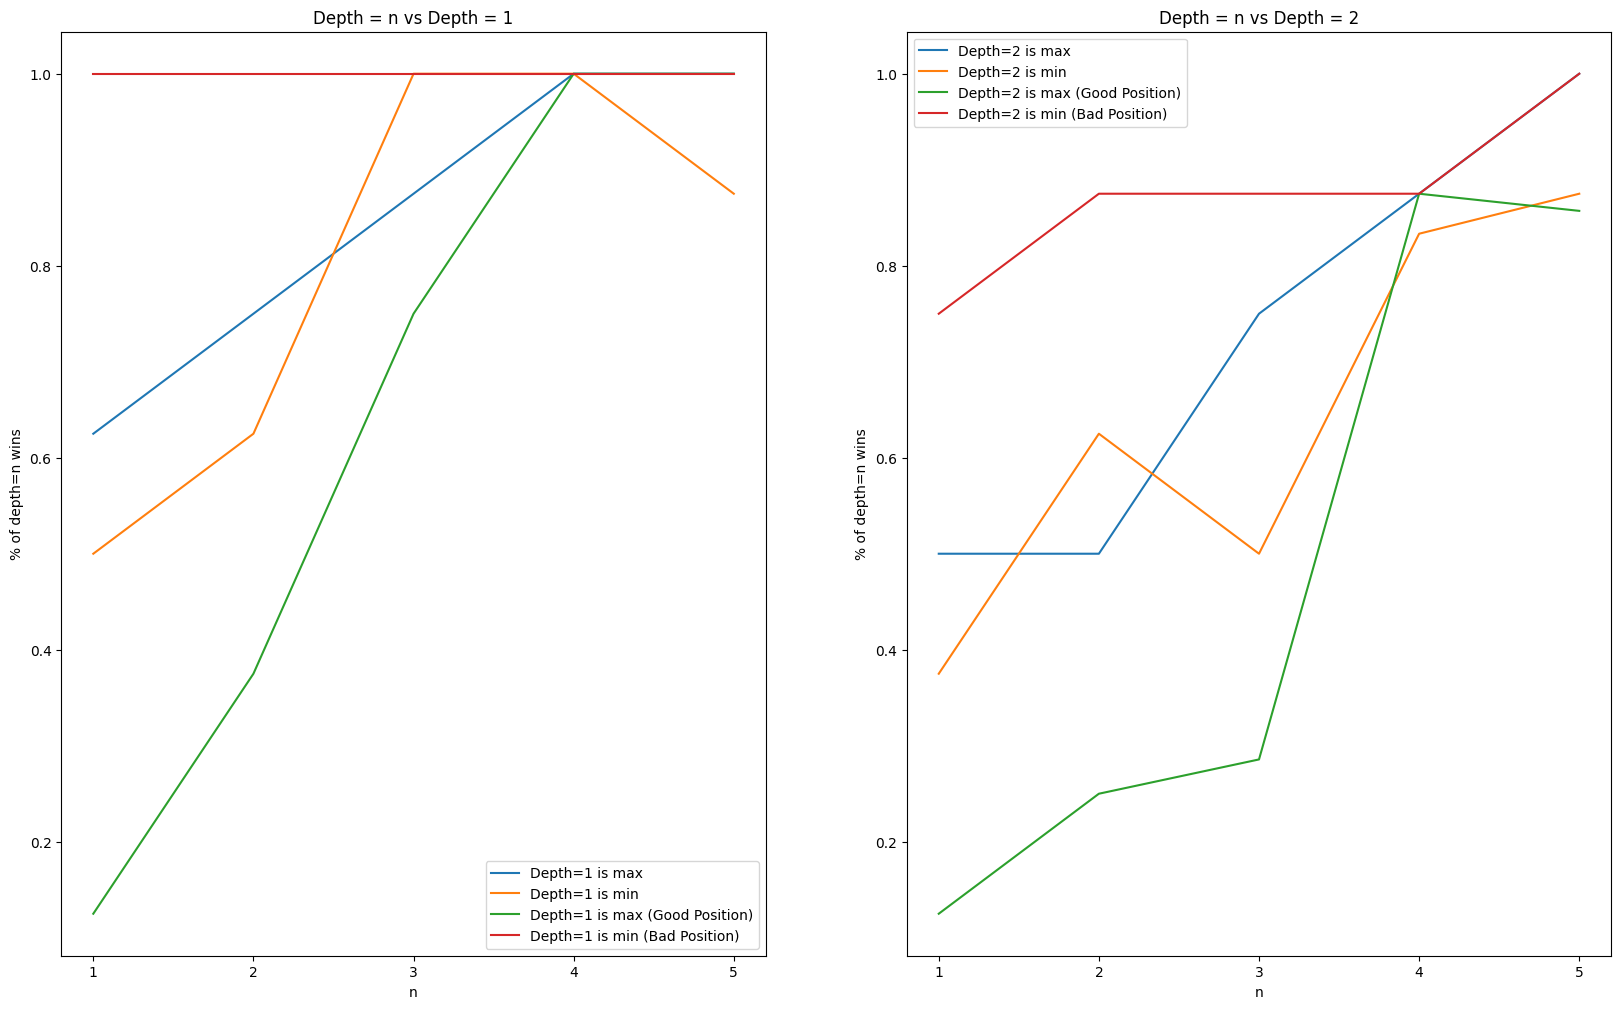

In [62]:
MULTIPLIER = {0:0, 1: 0, 2: 10, 3: 30, 4: 3000}

plots = minmaxPlots(5)
plots.plot_results()

# Generalne testy algorytmu

W tych testach algorytmu od samego początku wykonują wg uznania najlepsze ruchy 

In [63]:
is_n_first = True
for level in range(1, 6):
    p1 = Player("a")
    p2 = Player("b")
    game = ConnectFour2(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)
    minmax = MinMaxSolver(game)
    i=int(not is_n_first)
    while not game.is_finished():
        if i%2 == 0:
            game.make_move(ConnectFourMove(minmax.minimax(2, -INF, INF, is_n_first)[0]))
        else:
            game.make_move(ConnectFourMove(minmax.minimax(level, -INF, INF, not is_n_first)[0]))
        i%=2
        i+=1

    try:
        if game.get_winner().char == 'b':
            print(f'player depth={level} won vs player depth=2')
        else:
            print(f'player depth=2 won vs player depth={level}')
    except:
        pass


player depth=2 won vs player depth=1
player depth=2 won vs player depth=2
player depth=3 won vs player depth=2
player depth=4 won vs player depth=2
player depth=5 won vs player depth=2


In [64]:
is_n_first = False
for level in range(1, 7):
    p1 = Player("a")
    p2 = Player("b")
    game = ConnectFour2(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)
    minmax = MinMaxSolver(game)
    i=int(not is_n_first)
    while not game.is_finished():
        if i%2 == 0:
            game.make_move(ConnectFourMove(minmax.minimax(2, -INF, INF, is_n_first)[0]))
        else:
            game.make_move(ConnectFourMove(minmax.minimax(level, -INF, INF, not is_n_first)[0]))
        i%=2
        i+=1

    try:
        if game.get_winner().char == 'a':
            print(f'player depth={level} won vs player depth=2')
        else:
            print(f'player depth=2 won vs player depth={level}')
    except:
        pass


player depth=2 won vs player depth=1
player depth=2 won vs player depth=2
player depth=3 won vs player depth=2
player depth=5 won vs player depth=2
player depth=6 won vs player depth=2


# Porównanie czasowe alfa beta vs zwykły minmax

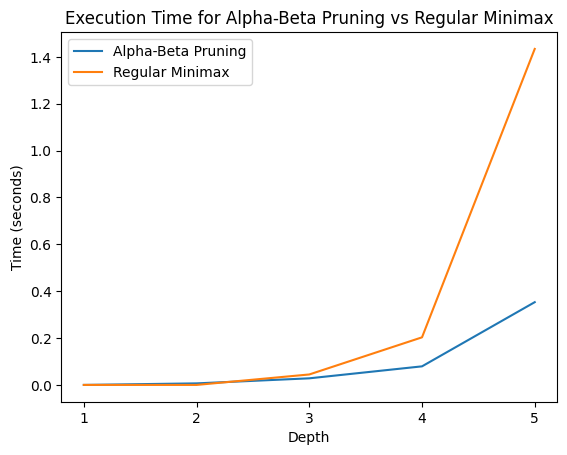

In [16]:
import time

def count_time(func, *args):
    start = time.time()
    func(*args)
    stop = time.time()
    return stop-start
p1 = Player("a")
p2 = Player("b")
game = ConnectFour2(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)
minmax = MinMaxSolver(game)

times_alphabeta = []
times_minmax = []

N = 6
for i in range(1,N):
    times_alphabeta.append(count_time(minmax.minimax,i, -INF, INF, False))
    times_minmax.append(count_time(minmax.just_minimax,i, False))

plt.plot(range(1, N), times_alphabeta, label='Alpha-Beta Pruning')
plt.plot(range(1, N), times_minmax, label='Regular Minimax')
plt.xlabel('Depth')
plt.xticks(range(1,N))
plt.ylabel('Time (seconds)')
plt.title('Execution Time for Alpha-Beta Pruning vs Regular Minimax')
plt.legend()
plt.show()

# depth 5 vs ja

In [137]:
p1 = Player("a")
p2 = Player("b")
game = ConnectFour2(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)
minmax = MinMaxSolver(game)
print("Jesteś graczzem a")
i=0
while not game.is_finished():
    if i%2 == 0:
        game.make_move(ConnectFourMove(int(input('Podaj ruch: '))))
    else:
        game.make_move(ConnectFourMove(minmax.minimax(5, -INF, INF, False)[0]))
    i%=2
    i+=1
    print(game)

try:
    print(f'player {game.get_winner().char} won')
except:
    pass

Jesteś graczzem a
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][a][ ]
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][b][a][ ]
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ 